In [610]:
import pandas as pd
import numpy as np
import random
import os
from scipy import signal
import statsmodels
from scipy.stats import norm
from math import factorial
import time
from scipy import stats
import scipy as scipy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(threshold=5)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn import neighbors
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

In [611]:
import os
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
from sklearn import decomposition
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import RANSACRegressor

yf.pdr_override()

START_DATE = "2010-01-01"
END_DATE = "2015-01-01"

In [612]:
tickers_mapping = pd.read_csv('Tickers.csv',  encoding='latin-1')
tickers_sorted = tickers_mapping.sort_values(['Sector']).Symbol
tickers_mapping.index = tickers_mapping['Symbol']

In [613]:
prices = pd.read_csv('stocks.csv')
prices.index = pd.DatetimeIndex(prices['Unnamed: 0'])
prices = prices.iloc[:,1:]
index = pd.read_csv('index.csv')
index.index = pd.DatetimeIndex(index['Date'])
raw_prices = pd.concat([prices, index['Adj Close'].rename('INDEX')], axis=1)        

returns = raw_prices.pct_change(1)
std_returns = returns.div(returns.std(0), 1)

betas = ((returns.rolling(60).corr(returns['INDEX']))*\
                            (returns.rolling(60).std().div(returns['INDEX'].rolling(60).std(),axis = 0))).shift(1)
idio_returns = returns - betas.mul(returns['INDEX'], axis = 0)
idio_std_returns = idio_returns.div(idio_returns.std(0), 1)

In [644]:
prices = pd.read_csv('stocks2.csv')
prices.index = pd.DatetimeIndex(prices['Unnamed: 0'])
prices = prices.iloc[:,1:]
index = pd.read_csv('index2.csv')
index.index = pd.DatetimeIndex(index['Date'])
raw_prices2 = pd.concat([prices, index['Adj Close'].rename('INDEX')], axis=1)        

returns2 = raw_prices2.pct_change(1)
std_returns2 = returns2.div(returns2.std(0), 1)

betas2 = ((returns2.rolling(60).corr(returns2['INDEX']))*\
                            (returns2.rolling(60).std().div(returns2['INDEX'].rolling(60).std(),axis = 0))).shift(1)
idio_returns2 = returns2 - betas2.mul(returns2['INDEX'], axis = 0)
idio_std_returns2 = idio_returns2.div(idio_returns2.std(0), 1)

In [645]:
clean_returns = returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_returns = idio_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_std_returns = idio_std_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)

clean_returns2 = returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_returns2 = idio_returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_std_returns2 = idio_std_returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)

In [646]:
clean_returns = clean_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_returns = clean_idio_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_std_returns = clean_idio_std_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]

clean_returns2 = clean_returns2.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_returns2 = clean_idio_returns2.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_std_returns2 = clean_idio_std_returns2.loc[:,list(set(clean_idio_returns.columns)&set(clean_idio_returns2.columns))]

In [647]:
clean_idio_std_returns.shape, clean_idio_std_returns2.shape

((1197, 447), (1198, 447))

Model

In [906]:
input_returns = clean_idio_std_returns
lags = 5
iteration = 1
stock = 'MSFT'
returns_table = input_returns.iloc[iteration:].rolling(lags).mean()[::lags]
rhs = returns_table.shift(1).dropna()
lhs = returns_table[[stock]].reindex(rhs.index)
lhs = pd.DataFrame(np.where(lhs > 0.0, 1, 0), index = lhs.index, columns = lhs.columns)

In [907]:
log_model = linear_model.LogisticRegression(penalty = 'elasticnet', max_iter = 500, l1_ratio = 1, \
                                            C = 0.12, solver='saga').fit(rhs, lhs)

coefs = log_model.coef_
coefs_df = pd.DataFrame(coefs, columns= rhs.columns)
rhs.shape, log_model.n_iter_, coefs_df[coefs_df != 0].dropna(1).count().sum()
coefs_df[coefs_df != 0].dropna(1).T.sort_index()

,0
GPS,0.144129
IBM,-0.415124
SLB,0.144085
UHS,-0.022647


In [908]:
input_returns = clean_idio_std_returns
lags = 5
iteration = 1
stock = 'MSFT'
returns_table = input_returns.iloc[iteration:].rolling(lags).mean()[::lags]
rhs = returns_table.shift(1).dropna()
lhs = returns_table[[stock]].reindex(rhs.index)

In [910]:
alphas, __, coefs = linear_model.lars_path(np.array(rhs), np.array(lhs).T[0], method='lasso', verbose=True)
coefs_df = pd.DataFrame(coefs.T, columns= rhs.columns).T[4]
coefs_df[coefs_df != 0].T.sort_index()

.

C       0.000450
IBM    -0.024993
INTU   -0.006942
UHS    -0.018238
Name: 4, dtype: float64

In [719]:
def lasso_two_steps(input_returns, output_returns, stock_list, lags, iteration, indicator, plot_this = False):
    
    output = {}
    output_coefs = {}
    
    for stock in stock_list:
        
        returns_table = input_returns.iloc[iteration:].rolling(lags).mean()[::lags]
        rhs = returns_table.shift(1).dropna()
        lhs = returns_table[[stock]].reindex(rhs.index)
        alphas, __, coefs = linear_model.lars_path(np.array(rhs), np.array(lhs).T[0], method='lasso', verbose=True)

        if plot_this == True:
            xx = np.sum(np.abs(coefs.T), axis=1)
            xx /= xx[-1]
            plt.plot(xx, coefs.T)
            ymin, ymax = plt.ylim()
            plt.vlines(xx, ymin, ymax, linestyle='dashed')
            plt.xlabel('|coef| / max|coef|')
            plt.ylabel('Coefficients')
            plt.title('LASSO Path')
            plt.axis('tight')
            plt.show()

        coefs_df = pd.DataFrame(coefs.T, columns= rhs.columns).T[indicator]
        selected_coefs = coefs_df[coefs_df != 0].index
        
        ransac = RANSACRegressor(random_state=0, min_samples=0.2, max_trials=500, \
                 loss = 'absolute_loss', stop_n_inliers = 0.8*len(rhs[selected_coefs])).fit(rhs[selected_coefs], lhs)
        print(ransac.n_trials_, rhs[selected_coefs].shape, rhs[selected_coefs][ransac.inlier_mask_].shape)
        lm_ins = sm.OLS(lhs[ransac.inlier_mask_], \
                                  sm.add_constant(rhs[selected_coefs][ransac.inlier_mask_])).fit()
        lm_outs = sm.OLS(lhs[np.logical_not(ransac.inlier_mask_)], \
                                  sm.add_constant(rhs[selected_coefs][np.logical_not(ransac.inlier_mask_)])).fit()

        linear_reg_model = sm.OLS(lhs, sm.add_constant(rhs[selected_coefs])).fit()  
        if plot_this == True:
            print(linear_reg_model.summary())
            print(lm_ins.summary())
            print(lm_outs.summary())
            print(pd.concat([pd.DataFrame(linear_reg_model.params), \
                             pd.DataFrame(lm_ins.params), \
                             pd.DataFrame(lm_outs.params)], 1))

        final_model = lm_ins
        rhs = output_returns.rolling(lags).mean().shift(1).dropna()
        lhs = output_returns[[stock]].reindex(rhs.index) 
        y_pred = final_model.predict(sm.add_constant(rhs[selected_coefs]))
        y_actual = lhs

        output[stock] = pd.DataFrame(columns= ['pred', 'actual'])
        output_coefs[stock] = pd.DataFrame(columns= ['coefs', 'tvals'])
        output[stock]['pred'] = y_pred
        output[stock]['actual'] = y_actual
        output_coefs[stock]['coefs'] = final_model.params
        output_coefs[stock]['tvals'] = final_model.tvalues
        output_coefs[stock]['coefs_explain'] = tickers_mapping.loc[final_model.params.index].Sector

    linear_model_output = pd.concat(output, 1)
    linear_model_output_coefs = pd.concat(output_coefs, 1)
    
    return linear_model_output, linear_model_output_coefs

In [720]:
def classify_results(table):
    table = table[(table['actual'] != 0) & table['pred'] != 0]
    classify_table = table/abs(table)
    c_matrix = confusion_matrix(classify_table['actual'], classify_table['pred'])
    c_matrix = c_matrix/(c_matrix.sum().sum())
    c_matrix = c_matrix.ravel()
    return (c_matrix[0] + c_matrix[3])

In [721]:
def reg_results(table):
    return abs(table['actual']).median() - abs(table['pred'] - table['actual']).median()

In [722]:
input_returns = clean_idio_returns
output_returns = clean_idio_returns2
stock_list = clean_idio_returns.columns[60:70]
indicators_list = range(10, 50)
reg_tests = {}
classify_tests = {}

for indicator in indicators_list:
    linear_model_output, linear_model_output_coefs = \
    lasso_two_steps(input_returns, output_returns, stock_list, lags = 5, iteration = 3, indicator = indicator)
    
    reg_tests[indicator] = np.median([reg_results(linear_model_output[stock]) for stock in stock_list])
    classify_tests[indicator] = np.median([classify_results(linear_model_output[stock]) for stock in stock_list])

.500 (237, 10) (131, 10)
.500 (237, 10) (134, 10)
.500 (237, 10) (133, 10)
.500 (237, 10) (124, 10)
.500 (237, 10) (138, 10)
.500 (237, 10) (131, 10)
.500 (237, 10) (140, 10)
.500 (237, 10) (133, 10)
.500 (237, 10) (124, 10)
.500 (237, 10) (127, 10)
.500 (237, 11) (131, 11)
.500 (237, 11) (134, 11)
.500 (237, 11) (134, 11)
.500 (237, 11) (125, 11)
.500 (237, 11) (139, 11)
.500 (237, 11) (127, 11)
.500 (237, 11) (138, 11)
.500 (237, 11) (134, 11)
.500 (237, 11) (119, 11)
.500 (237, 11) (129, 11)
.500 (237, 12) (131, 12)
.500 (237, 12) (133, 12)
.500 (237, 12) (131, 12)
.500 (237, 12) (127, 12)
.500 (237, 12) (141, 12)
.500 (237, 12) (128, 12)
.500 (237, 12) (139, 12)
.500 (237, 12) (132, 12)
.500 (237, 12) (119, 12)
.500 (237, 12) (127, 12)
.500 (237, 13) (129, 13)
.500 (237, 13) (133, 13)
.500 (237, 13) (130, 13)
.500 (237, 13) (127, 13)
.500 (237, 13) (141, 13)
.500 (237, 13) (126, 13)
.500 (237, 13) (137, 13)
.500 (237, 13) (134, 13)
.500 (237, 13) (117, 13)
.500 (237, 13) (128, 13)


.500 (237, 42) (110, 42)
.500 (237, 42) (116, 42)
.500 (237, 42) (114, 42)
.500 (237, 41) (128, 41)
.500 (237, 41) (134, 41)
.500 (237, 43) (97, 43)
.500 (237, 41) (128, 41)
.500 (237, 41) (115, 41)
.500 (237, 41) (127, 41)
.500 (237, 43) (112, 43)
.500 (237, 43) (106, 43)
.500 (237, 43) (106, 43)
.500 (237, 42) (114, 42)
.500 (237, 42) (122, 42)
.500 (237, 42) (117, 42)
.500 (237, 44) (101, 44)
.500 (237, 42) (126, 42)
.500 (237, 42) (111, 42)
.500 (237, 42) (127, 42)
.500 (237, 44) (117, 44)
.500 (237, 44) (104, 44)
.500 (237, 44) (108, 44)
.500 (237, 43) (112, 43)
.500 (237, 43) (114, 43)
.500 (237, 43) (116, 43)
.500 (237, 45) (101, 45)
.500 (237, 43) (114, 43)
.500 (237, 43) (108, 43)
.500 (237, 43) (119, 43)
.500 (237, 45) (117, 45)
.500 (237, 45) (100, 45)
.500 (237, 45) (103, 45)
.500 (237, 44) (117, 44)
.500 (237, 44) (120, 44)
.500 (237, 44) (110, 44)
.500 (237, 46) (94, 46)
.500 (237, 44) (115, 44)
.500 (237, 44) (104, 44)
.500 (237, 44) (113, 44)
.500 (237, 46) (116, 46)
.5

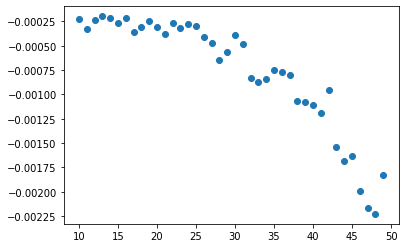

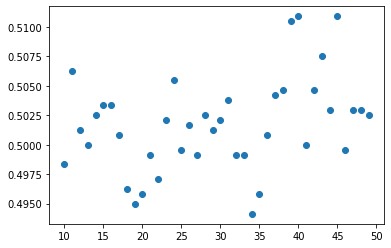

In [723]:
plt.scatter(pd.Series(reg_tests).index, pd.Series(reg_tests))
plt.show()
plt.scatter(pd.Series(classify_tests).index, pd.Series(classify_tests))
plt.show()

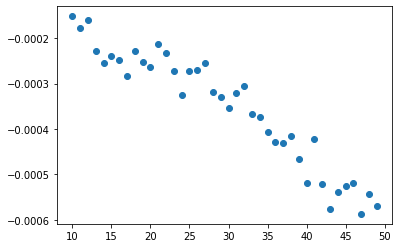

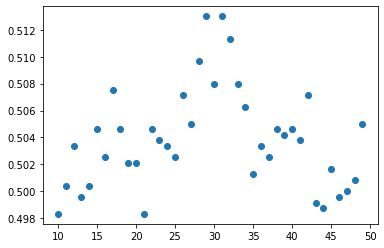

In [718]:
plt.scatter(pd.Series(reg_tests).index, pd.Series(reg_tests))
plt.show()
plt.scatter(pd.Series(classify_tests).index, pd.Series(classify_tests))
plt.show()

In [572]:
tmp = linear_model_output_coefs.swaplevel(0, 1, 1)['coefs_explain']
for this_stock in stock_list:
    print (tickers_mapping.loc[this_stock]['Sector'], '\n', tmp[this_stock].value_counts())
    break

Consumer Discretionary 
 Information Technology    2
Health Care               1
Consumer Discretionary    1
Name: LEG, dtype: int64


Demo

....................................................................................................

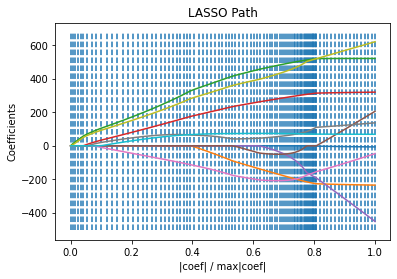

In [453]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

alphas,coefs, __ = linear_model.enet_path(X, y, l1_ratio = 0.995, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [566]:
ransac = RANSACRegressor(random_state=0, min_samples=0.2, max_trials=500, \
                         loss = 'absolute_loss', stop_n_inliers = 0.8*len(X)).fit(X, y)
print(ransac.n_trials_, X.shape, X[ransac.inlier_mask_].shape)

lm = sm.OLS(y[ransac.inlier_mask_], sm.add_constant(X[ransac.inlier_mask_])).fit()
lm2 = sm.OLS(y[np.logical_not(ransac.inlier_mask_)], sm.add_constant(X[np.logical_not(ransac.inlier_mask_)])).fit()

pd.concat([pd.DataFrame(lm.params), pd.DataFrame(lm2.params)], 1)

500 (442, 10) (329, 10)


,0,0
0,147.447009,172.759977
1,-107.405940,290.405654
2,-284.043225,29.991201
3,516.322263,493.521692
4,282.279815,170.362477
5,-483.032516,"-1,063.906226"
6,180.188276,822.706856
7,-28.796839,540.489658
8,141.842043,260.627168
9,830.026764,521.489720


....................................................................................................

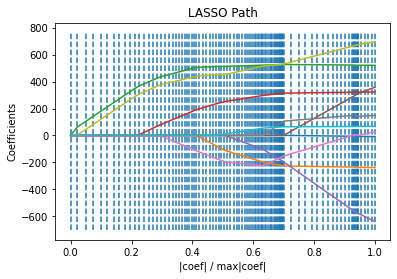

In [230]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

alphas,coefs, __ = linear_model.lasso_path(X, y,  method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [797]:
X, y = datasets.make_classification(n_samples=100000, n_features=100,
                                    n_informative=50, n_redundant=50)
log_model = linear_model.LogisticRegression(penalty= 'elasticnet', max_iter= 100, l1_ratio= 1, \
                                            C = 0.001, solver='saga').fit(X, y)

coefs = log_model.coef_
coefs_df = pd.DataFrame(coefs.T).T
X.shape, log_model.n_iter_, coefs_df[coefs_df != 0].dropna(1).T.count()

((100000, 100),
 array([29]),
 0    46
 dtype: int64)